In [33]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec
from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders

In [34]:
import os
import random
import csv
import matplotlib.pyplot as plt

# Define time parameters
end_time = 60 * 10 # 3 minutes simulation time

# Define trader specifications
traders_spec = {
    'buyers': [('ZIP', 10), ('OFITrader', 10)],
    'sellers': [('ZIP', 10), ('OFITrader', 10)],
}

# Define order schedule
order_schedule = {
    'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'timemode': 'drip-fixed',
    'interval': 2,
}

# Function to run a single market session and log data directly to a CSV file
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """
    Runs a market session and appends results to the provided file object.
    """
    # Initialize the exchange
    exchange = Exchange()
    
    # Create traders
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)
    
    # Set the time parameters
    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        # Track time remaining
        time_left = (endtime - time) / (endtime - starttime)
        
        # Generate and process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, 
            last_update=-1, 
            traders=traders, 
            trader_stats=trader_stats,
            os=order_schedule, 
            pending=pending_cust_orders, 
            verbose=verbose
        )
        
        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))
        
        # Process the order if it exists
        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log statistics for this time step
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob)

        # Increment time
        time += timestep

def write_trade_stats(expid, traders, tdump, time, lob):
    trader_types = {}
    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        balance = trader.balance
        profit = balance  # Replace with correct profit calculation

        # Handle negative profits gracefully
        if profit < 0:
            print(f"WARNING: Trader {t} ({ttype}) has negative profit: {profit}")
            continue  # Log the issue, but do not exit

        if ttype in trader_types:
            trader_types[ttype]['balance_sum'] += balance
            trader_types[ttype]['n'] += 1
        else:
            trader_types[ttype] = {
                'balance_sum': balance,
                'n': 1
            }

    for ttype, stats in trader_types.items():
        avg_profit = stats['balance_sum'] / stats['n']
        tdump.write(
            f"{expid},{time},{lob['bids']['best']},{lob['asks']['best']},"
            f"{ttype},{stats['balance_sum']},{stats['n']},{avg_profit}\n"
        )

# Main script to run the experiment
output_file = 'bigtestdata.csv'
with open(output_file, 'w') as tdump:
    # Write a header for your CSV file
    tdump.write("Trial,Time,BestBid,BestAsk,TraderType,Balance,Profit,ProfitType\n")

    # Run multiple independent trials
    trial = 1
    max_trials = 10  # Number of trials to run
    while trial <= max_trials:
        tid = f'trial{trial:04d}'  # Unique ID for each trial
        print(f"Running trial {trial}/{max_trials}...")  # Optional: track progress

        # Run a single market session
        market_session_with_logging(
            tid,              # Session ID
            0.0,              # Start time
            end_time,         # End time
            traders_spec,     # Trader specifications
            order_schedule,   # Order schedule
            {
                'dump_tape': False,
                'dump_strats': False,
                'dump_lobs': False,
                'dump_blotters': False,
                'dump_avgbals': False,  # Turn off extra logging to avoid folder output
            },
            verbose=False,     # Verbose flag (set to True for debugging)
            tdump=tdump        # Pass the open file handle for appending results
        )

        trial += 1

# Inform the user of completion
print(f"Completed {max_trials} trials. Results saved to {output_file}.")


Running trial 1/10...
Running trial 2/10...
Running trial 3/10...
Running trial 4/10...
Running trial 5/10...
Running trial 6/10...
Running trial 7/10...


KeyboardInterrupt: 

In [ ]:
import os
import random
import csv
import numpy as np
import matplotlib.pyplot as plt

start_time = 0
end_time = 60 * 10
order_interval = 10
chart1_range=(80, 320)
range1=(10, 190)
range2=(200, 320)
range3=(20, 320)


# Standard market conditions 
quantity = 5
sellers_spec = [('ZIP', quantity)]
buyers_spec = [('ZIP', quantity)]

traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'random'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'random'}]

order_schedule = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': 'drip-poisson',
    'fittointerval': False
}

verbose = False

dump_flags = {
    'dump_blotters': True,
    'dump_lobs': True,
    'dump_strats': True,
    'dump_avgbals': True,
    'dump_tape': True
}

n_sessions = 1

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'new_trader_chart_' + str(sess)

    # Run a market session and assume it returns the Exchange instance
    exchange = market_session(trial_id, start_time, end_time, traders_spec, order_schedule, dump_flags, verbose)

    # Dump the tape from the exchange to a CSV file.
    tape_fname = trial_id + '_tape.csv'
    with open(tape_fname, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write a header (adjust column order if needed)
        writer.writerow(["Time", "Price", "Party1", "Party2"])
        # Write each trade from the tape
        for trade in exchange.tape:
            writer.writerow([trade['t'], trade['price'], trade['party1'], trade['party2']])

    # Now read the tape CSV file and collect data for plotting.
    with open(tape_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Skip header
        next(reader)
        for row in reader:
            time_val = float(row[0])
            price_val = float(row[1])
            x = np.append(x, time_val)
            y = np.append(y, price_val)

plt.figure(figsize=(20, 6))
plt.plot(x, y, 'x', color='black')
plt.xlabel("Trade Time (s)")
plt.ylabel("Price")
plt.show()


AttributeError: 'NoneType' object has no attribute 'tape'

TraderType: ZIP, Trials: ['trial0001' 'trial0002' 'trial0003' 'trial0004' 'trial0005' 'trial0006'
 'trial0007' 'trial0008' 'trial0009' 'trial0010']


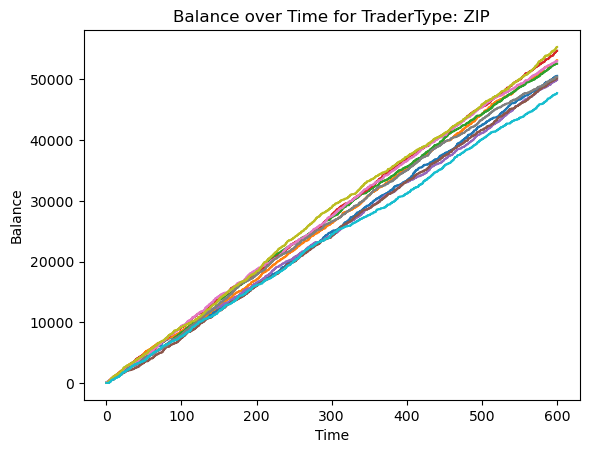

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('bigtestdata.csv')

# Plot AvgProfit over Time for Each TraderType on separate graphs
# Iterate over each TraderType to create separate plots
for trader_type in df['TraderType'].unique():
    plt.figure()
    trader_data = df[df['TraderType'] == trader_type]
    print(f'TraderType: {trader_type}, Trials: {trader_data["Trial"].unique()}')  # Debug print
    for trial in trader_data['Trial'].unique():
        trial_data = trader_data[trader_data['Trial'] == trial]
        plt.plot(trial_data['Time'], trial_data['Balance'], label=f'Trial {trial}')
    plt.xlabel('Time')
    plt.ylabel('Balance')
    plt.title(f'Balance over Time for TraderType: {trader_type}')
    #plt.legend()
    plt.show()
    
    plt.show()

In [ ]:

df = pd.read_csv('bigtestdata.csv')
df

,Trial,Time,BestBid,BestAsk,TraderType,Balance,Profit,ProfitType
0,trial0001,0.00,None,None,ZIP,0.0,20,0.0
1,trial0001,0.05,None,None,ZIP,0.0,20,0.0
2,trial0001,0.10,None,None,ZIP,0.0,20,0.0
3,trial0001,0.15,None,None,ZIP,0.0,20,0.0
4,trial0001,0.20,94,None,ZIP,0.0,20,0.0
...,...,...,...,...,...,...,...,...
119995,trial0010,599.75,77,90,ZIP,47696.0,20,2384.8
119996,trial0010,599.80,77,90,ZIP,47696.0,20,2384.8
119997,trial0010,599.85,77,90,ZIP,47696.0,20,2384.8
119998,trial0010,599.90,77,99,ZIP,47762.0,20,2388.1


In [ ]:
'''

# Plot TotalProfit over Time for Each TraderType on separate graphs
for trader_type in df['TraderType'].unique():
    plt.figure()
    trader_data = df[df['TraderType'] == trader_type]
    for trial in trader_data['Trial'].unique():
        trial_data = trader_data[trader_data['Trial'] == trial]
        plt.plot(trial_data['Time'], trial_data['Balance'], label=f'Trial {trial}')
    plt.xlabel('Time')
    plt.ylabel('TotalProfit')
    plt.title(f'TotalProfit over Time for TraderType: {trader_type}')
    plt.legend()
    #plt.show()
'''


"\n\n# Plot TotalProfit over Time for Each TraderType on separate graphs\nfor trader_type in df['TraderType'].unique():\n    plt.figure()\n    trader_data = df[df['TraderType'] == trader_type]\n    for trial in trader_data['Trial'].unique():\n        trial_data = trader_data[trader_data['Trial'] == trial]\n        plt.plot(trial_data['Time'], trial_data['Balance'], label=f'Trial {trial}')\n    plt.xlabel('Time')\n    plt.ylabel('TotalProfit')\n    plt.title(f'TotalProfit over Time for TraderType: {trader_type}')\n    plt.legend()\n    #plt.show()\n"

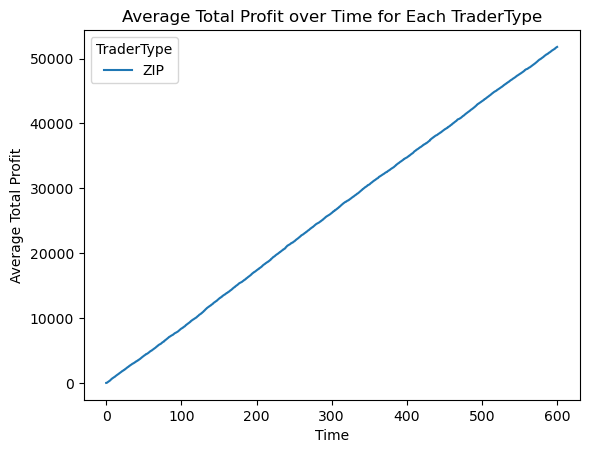

In [ ]:
# Group the data by Time and TraderType, and calculate the mean TotalProfit for each group
avg_total_profit = df.groupby(['Time', 'TraderType'])['Balance'].mean().unstack()

# Plot the average total profit over time for each trader type
avg_total_profit.plot()
plt.xlabel('Time')
plt.ylabel('Average Total Profit')
plt.title('Average Total Profit over Time for Each TraderType')
plt.legend(title='TraderType')
plt.show()

### Need to toggle of fthe if profit < 0:

Allowing negative profits 

In [ ]:
import os
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders

# Define time parameters
end_time = 60 * 2  # 2 minutes simulation time

# Define trader specifications
traders_spec = {
    'buyers': [('SNPR', 2),('OFITrader', 2), ('ZIC', 2)],
    'sellers': [('SNPR', 2),('OFITrader', 2), ('ZIC', 2)],
}

# Define order schedule
order_schedule = {
    'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'timemode': 'drip-fixed',
    'interval': 1,
}

# === Trader Class (Tracks Initial Balance for Profit Calculation) ===
class Trader:
    def __init__(self, ttype, tid, balance, params, time):
        self.ttype = ttype
        self.tid = tid
        self.balance = balance
        self.initial_balance = balance  # Store starting balance
        self.orders = []
        self.blotter = []
        self.n_trades = 0

    def bookkeep(self, trade, order, verbose, time):
        transaction_price = trade['price']
        if order.otype == 'Bid':  # Buying
            profit = order.price - transaction_price
        else:  # Selling
            profit = transaction_price - order.price

        self.balance += profit  # Update balance
        self.n_trades += 1

        if verbose:
            print(f"{self.tid}: Profit={profit}, Balance={self.balance}")

# === Function to Run a Single Market Session ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """Runs a market session and logs data."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log trader statistics
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob)

        time += timestep

# === Function to Log Trader Statistics in CSV ===
def write_trade_stats(expid, traders, tdump, time, lob):
    trader_types = {}

    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        balance = trader.balance
        profit = balance - trader.balance  # Compute net profit (positive or negative)

        # Track statistics for each trader type
        if ttype in trader_types:
            trader_types[ttype]['balance_sum'] += balance
            trader_types[ttype]['profit_sum'] += profit
            trader_types[ttype]['n'] += 1
        else:
            trader_types[ttype] = {'balance_sum': balance, 'profit_sum': profit, 'n': 1}

    # Write results to CSV
    for ttype, stats in trader_types.items():
        avg_profit = stats['profit_sum'] / stats['n']
        profit_type = "Positive" if stats['profit_sum'] >= 0 else "Negative"

        tdump.write(
            f"{expid},{time},{lob['bids']['best']},{lob['asks']['best']},"
            f"{ttype},{stats['balance_sum']},{stats['profit_sum']},{profit_type}\n"
        )

# === Run Multiple Market Sessions and Save to CSV ===
output_file = 'bigtestdata.csv'
with open(output_file, 'w') as tdump:
    tdump.write("Trial,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType\n")

    max_trials = 100
    for trial in range(1, max_trials + 1):
        tid = f'trial{trial:04d}'
        print(f"Running trial {trial}/{max_trials}...")

        market_session_with_logging(
            tid, 0.0, end_time, traders_spec, order_schedule,
            {
                'dump_tape': False, 'dump_strats': False,
                'dump_lobs': False, 'dump_blotters': False,
                'dump_avgbals': False,
            },
            verbose=False, tdump=tdump
        )

print(f"Completed {max_trials} trials. Results saved to {output_file}.")


Running trial 1/100...
Running trial 2/100...
Running trial 3/100...
Running trial 4/100...
Running trial 5/100...
Running trial 6/100...
Running trial 7/100...
Running trial 8/100...
Running trial 9/100...
Running trial 10/100...
Running trial 11/100...
Running trial 12/100...
Running trial 13/100...
Running trial 14/100...
Running trial 15/100...
Running trial 16/100...
Running trial 17/100...
Running trial 18/100...
Running trial 19/100...
Running trial 20/100...
Running trial 21/100...
Running trial 22/100...
Running trial 23/100...
Running trial 24/100...
Running trial 25/100...
Running trial 26/100...
Running trial 27/100...
Running trial 28/100...
Running trial 29/100...
Running trial 30/100...
Running trial 31/100...
Running trial 32/100...
Running trial 33/100...
Running trial 34/100...
Running trial 35/100...
Running trial 36/100...
Running trial 37/100...
Running trial 38/100...
Running trial 39/100...
Running trial 40/100...
Running trial 41/100...
Running trial 42/100...
R

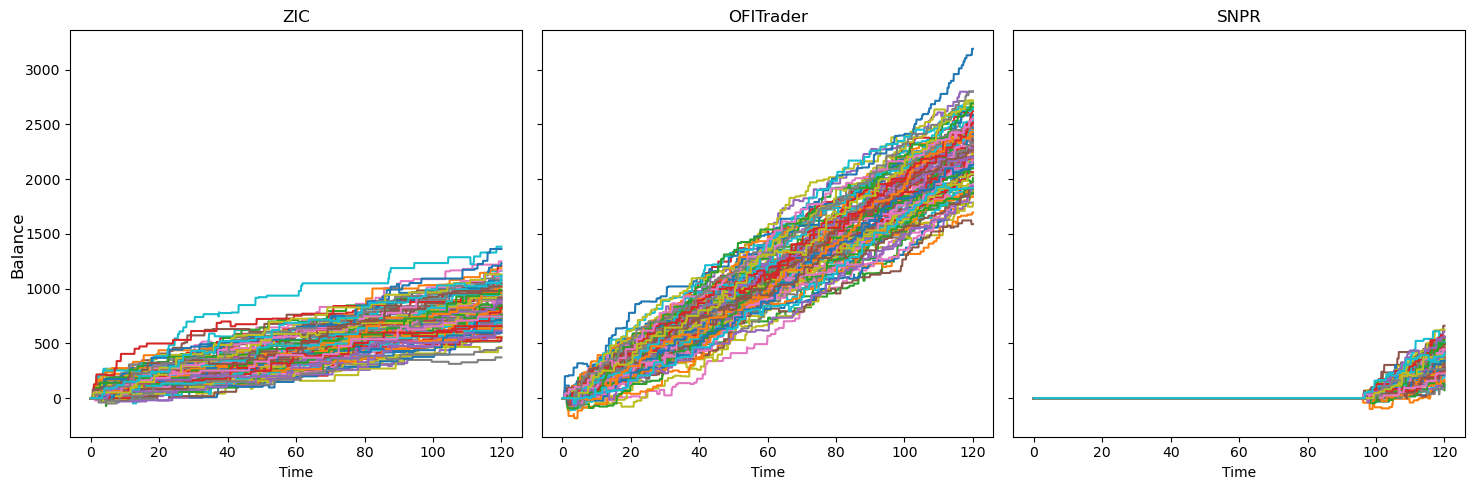

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('bigtestdata.csv')

# Get unique trader types
trader_types = df['TraderType'].unique()
num_traders = len(trader_types)

# Create a single-row, multi-column subplot layout
fig, axes = plt.subplots(nrows=1, ncols=num_traders, figsize=(5 * num_traders, 5), sharey=True)

# If there's only one trader type, `axes` is not a list, so we wrap it
if num_traders == 1:
    axes = [axes]

# Iterate over each TraderType and plot on separate subplots
for ax, trader_type in zip(axes, trader_types):
    trader_data = df[df['TraderType'] == trader_type]
    for trial in trader_data['Trial'].unique():
        trial_data = trader_data[trader_data['Trial'] == trial]
        ax.plot(trial_data['Time'], trial_data['Balance'], label=f'Trial {trial}')
    
    ax.set_xlabel('Time')
    ax.set_title(f'{trader_type}')

# Add common Y-axis label
fig.supylabel('Balance')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# This is useful from here down 

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec
from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders

In [ ]:
import os
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from BSE import Exchange, market_session, populate_market, customer_orders

# Define time parameters
end_time = 60 * 5  # 2 minutes simulation time

#('DepthBasedTrader', 1)

# Define trader specifications
traders_spec = {
    'buyers': [('OFITrader', 1), ('ZIC', 1), ('MarketMaker', 1), ('ZIP', 1) ],
    'sellers': [('OFITrader', 1), ('ZIC', 1),  ('MarketMaker', 1), ('ZIP', 1)],
}

# Define order schedule
order_schedule = {
    'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'timemode': 'drip-fixed',
    'interval': 1,
}

# === Trader Class (Tracks Initial Balance for Profit Calculation) ===
class Trader:
    def __init__(self, ttype, tid, balance, params, time):
        self.ttype = ttype
        self.tid = tid
        self.balance = balance
        self.initial_balance = balance  # Store starting balance
        self.orders = []
        self.blotter = []
        self.n_trades = 0

    def bookkeep(self, trade, order, verbose, time):
        transaction_price = trade['price']
        if order.otype == 'Bid':  # Buying
            profit = order.price - transaction_price
        else:  # Selling
            profit = transaction_price - order.price

        self.balance += profit  # Update balance
        self.n_trades += 1

        if verbose:
            print(f"{self.tid}: Profit={profit}, Balance={self.balance}")

# === Function to Run a Single Market Session ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """Runs a market session and logs data."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log trader statistics
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob)

        time += timestep

# === Function to Log Trader Statistics in CSV ===
def write_trade_stats(expid, traders, tdump, time, lob):
    trader_types = {}

    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        balance = trader.balance
        profit = balance - trader.initial_balance  # Corrected profit calculation

        # Track statistics for each trader type
        if ttype in trader_types:
            trader_types[ttype]['balance_sum'] += balance
            trader_types[ttype]['profit_sum'] += profit 
            trader_types[ttype]['n'] += 1
        else:
            trader_types[ttype] = {'balance_sum': balance, 'profit_sum': profit, 'n': 1}

    # Write results to CSV
    for ttype, stats in trader_types.items():
        avg_profit = stats['profit_sum'] / stats['n']
        profit_type = "Positive" if stats['profit_sum'] >= 0 else "Negative"

        tdump.write(
            f"{expid},{time},{lob['bids']['best']},{lob['asks']['best']},"
            f"{ttype},{stats['balance_sum']},{stats['profit_sum']},{profit_type}\n"
        )

# === Run Multiple Market Sessions and Save to CSV ===
output_file = 'bigtestdata.csv'
with open(output_file, 'w') as tdump:
    tdump.write("Trial,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType\n")

    max_trials = 10
    for trial in range(1, max_trials + 1):
        tid = f'trial{trial:04d}'
        print(f"Running trial {trial}/{max_trials}...")

        market_session_with_logging(
            tid, 0.0, end_time, traders_spec, order_schedule,
            {
                'dump_tape': False, 'dump_strats': False,
                'dump_lobs': False, 'dump_blotters': False,
                'dump_avgbals': False,
            },
            verbose=False, tdump=tdump
        )

print(f"Completed {max_trials} trials. Results saved to {output_file}.")


Running trial 1/10...
Running trial 2/10...
Running trial 3/10...
Running trial 4/10...
Running trial 5/10...
Running trial 6/10...
Running trial 7/10...
Running trial 8/10...
Running trial 9/10...
Running trial 10/10...
Completed 10 trials. Results saved to bigtestdata.csv.


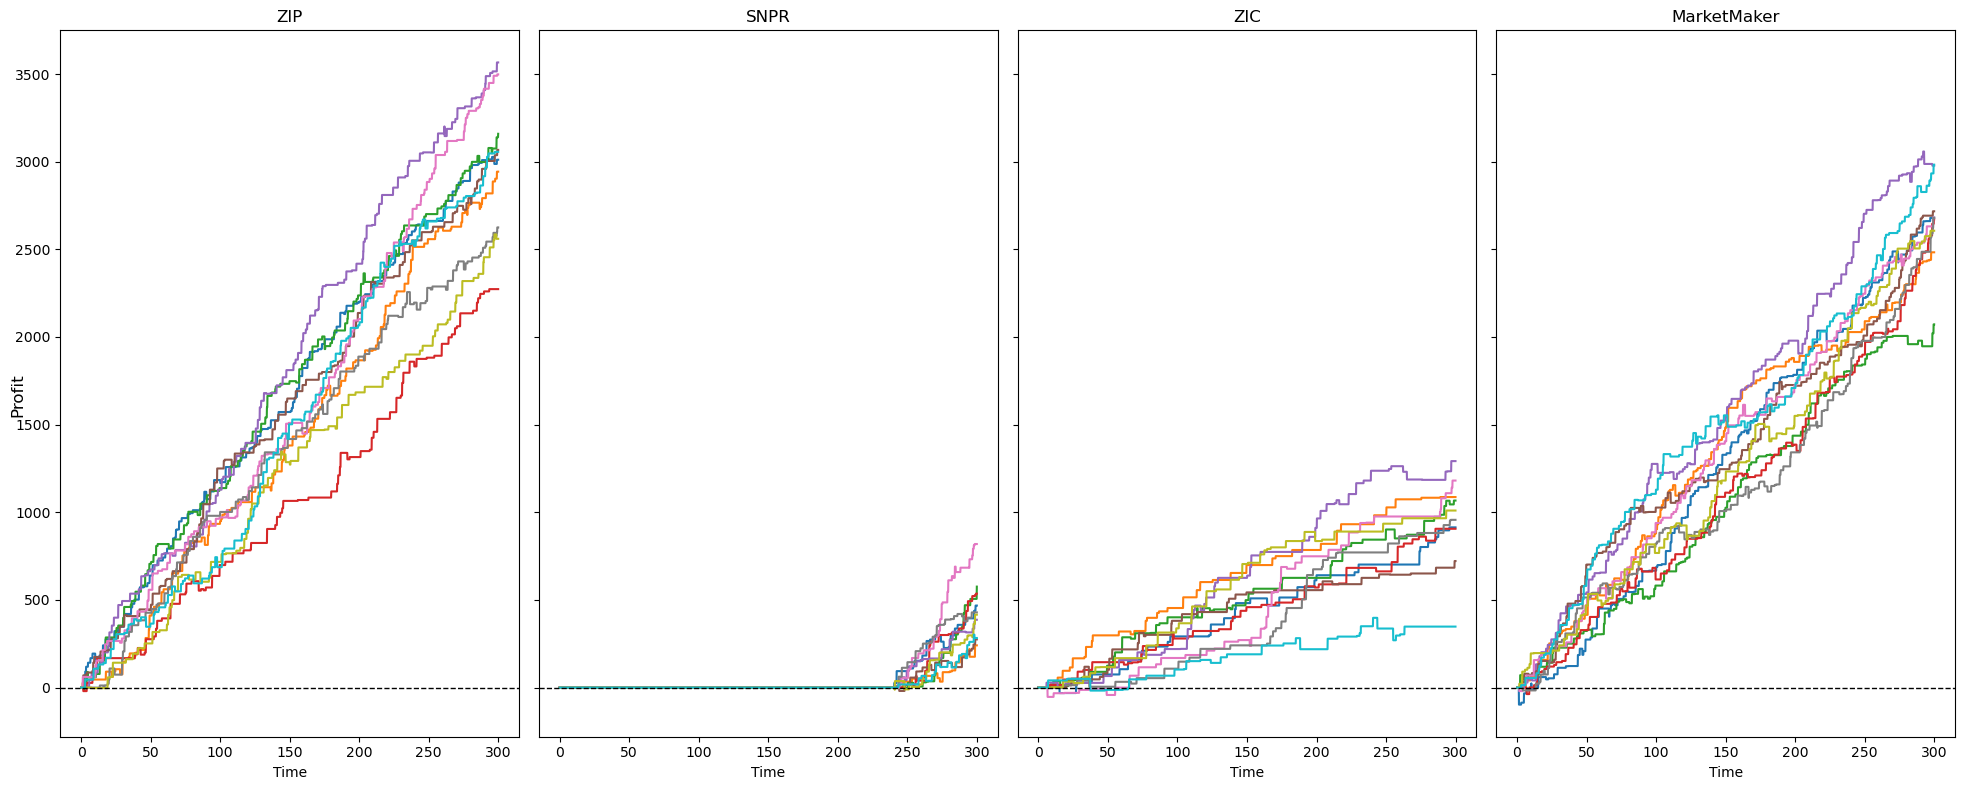

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('bigtestdata.csv')

# Get unique trader types
trader_types = df['TraderType'].unique()
num_traders = len(trader_types)

# Create a single-row, multi-column subplot layout
fig, axes = plt.subplots(nrows=1, ncols=num_traders, figsize=(5 * num_traders, 8), sharey=True)

# If there's only one trader type, `axes` is not a list, so we wrap it
if num_traders == 1:
    axes = [axes]

# Iterate over each TraderType and plot on separate subplots
for ax, trader_type in zip(axes, trader_types):
    trader_data = df[df['TraderType'] == trader_type]
    for trial in trader_data['Trial'].unique():
        trial_data = trader_data[trader_data['Trial'] == trial]
        ax.plot(trial_data['Time'], trial_data['TotalProfit'], label=f'Trial {trial}')
    
    # Add horizontal line at y = 0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    ax.set_xlabel('Time')
    ax.set_title(f'{trader_type}')

# Add common Y-axis label
fig.supylabel('Profit')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# Filter the dataframe to get the final time point
final_time = df['Time'].max()
final_data = df[df['Time'] == final_time]

# Group by TraderType and calculate the mean, standard deviation, and variance of TotalProfit
profit_stats = final_data.groupby('TraderType')['TotalProfit'].agg(['mean', 'std', 'var'])

print(profit_stats)

              mean         std           var
TraderType                                  
MarketMaker  168.3  100.920266  10184.900000
SNPR          30.6   31.760213   1008.711111
ZIC          157.7   91.475619   8367.788889
ZIP          263.5  114.870217  13195.166667


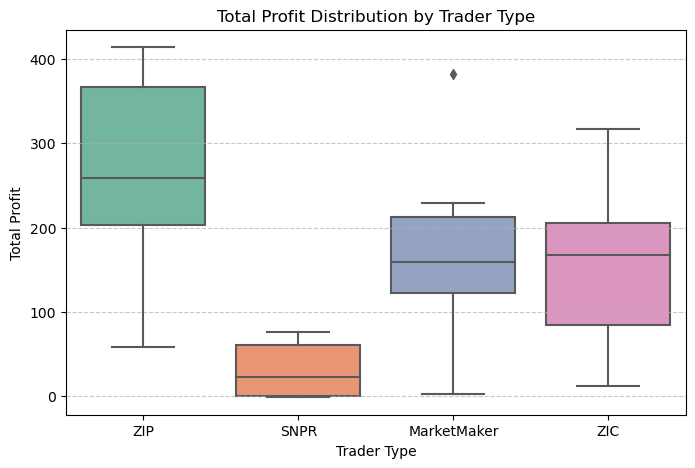

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x='TraderType', y='TotalProfit', data=final_data, palette="Set2")

plt.xlabel('Trader Type')
plt.ylabel('Total Profit')
plt.title('Total Profit Distribution by Trader Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
